# For playing with YASA and sleep data in an individual file, focussing on wakings specifically


In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter


In [3]:
log = lambda msg: logging.info(msg)


# Load MNE data

In [4]:
input_file = "C:\\dev\\play\\brainwave-data\\2024-09-01-21-11-15\\raw.fif"

In [5]:
log(f"Reading file {input_file}")
raw = mne.io.read_raw_fif(input_file, preload=True)
log(f"Finished reading file {input_file}")
input_file_without_ext = os.path.splitext(input_file)[0]


Opening raw data file C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.fif...
Isotrak not found
    Range : 0 ... 8209044 =      0.000 ... 32836.176 secs
Ready.
Reading 0 ... 8209044  =      0.000 ... 32836.176 secs...


In [6]:
from datetime import datetime, timedelta

channels = raw.info['ch_names']
sfreq = raw.info['sfreq']
start_date = raw.info['meas_date']
end_date = start_date + timedelta(seconds=float(raw.times[-1]))

display(channels)
display(sfreq)
display(start_date)
display(input_file_without_ext)
display(raw.n_times)
display(raw.times[0])
display(raw.times[-1])
display(end_date)


['Fpz-M1']

250.0

datetime.datetime(2024, 9, 1, 20, 11, 15, 609066, tzinfo=datetime.timezone.utc)

'C:\\dev\\play\\brainwave-data\\2024-09-01-21-11-15\\raw'

8209045

0.0

32836.176

datetime.datetime(2024, 9, 2, 5, 18, 31, 785066, tzinfo=datetime.timezone.utc)

In [7]:
mne_filtered = run_yasa.get_filtered_and_scaled_data(raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



In [8]:
d = mne_filtered.get_data(units = "uV")

In [9]:
np.set_printoptions(suppress=True, precision=10)

#mne_filtered.plot()

## Save to EDF


In [16]:
resampled = mne_filtered.copy()
# 100 hz is very similar to 250 hz to naked eye.  50 gets too lossy.
resampled.resample(100, npad="auto")

mne.export.export_raw(input_file_without_ext + ".edf", resampled, overwrite=True)

Overwriting existing file.


C:\Users\graha\AppData\Local\Temp\ipykernel_10840\1686795499.py:4: RuntimeWarning: EDF format requires equal-length data blocks, so 0.14 seconds of zeros were appended to all channels when writing the final block.
  mne.export.export_raw(input_file_without_ext + ".edf", resampled, overwrite=True)


In [17]:
resampled.plot()

<mne_qt_browser._pg_figure.MNEQtBrowser(0x2058071ae60) at 0x000002051474FD00>

In [15]:
mne_filtered.plot()


<mne_qt_browser._pg_figure.MNEQtBrowser(0x205805c0e80) at 0x000002051441B940>

## Load other data

In [ ]:
# Manual wakings - must be adjusted
from datetime import datetime, timedelta

# Calculate the start and end times for the waking period
waking_start_time = (start_date + timedelta(days=1)).replace(hour=0, minute=9)
waking_end_time = (start_date + timedelta(days=1)).replace(hour=1, minute=19)

In [4]:
import firebase_admin
from firebase_admin import credentials, firestore
import os

# Initialize Firebase (assuming you have the necessary credentials)
home_dir = os.path.expanduser("~")
firebase_credentials_path = os.path.join(home_dir, "examined-life-dd234-firebase-adminsdk-f515f-124ed5962e.json")

cred = credentials.Certificate(firebase_credentials_path)
firebase_admin.initialize_app(cred)

db = firestore.client()

# Query Firestore
docs = db.collection('homeAssistantExperimental') \
    .stream()
    # .where('timestamp', '>=', start.to_firestore()) \
    # .where('timestamp', '<=', end.to_firestore()) \

# Convert to list of dictionaries
records = [doc.to_dict() for doc in docs]

In [22]:
import pandas as pd
ha_events = pd.DataFrame(records)
ha_events

,event,timestamp
0,pee,2024-04-28 23:55:27.052000+00:00
1,"lights out, ready for sleep",2024-04-29 00:24:15.022000+00:00
2,wake,2024-04-29 02:10:23.304000+00:00
3,wake,2024-04-29 02:36:20.663000+00:00
4,wake,2024-04-29 02:59:55.701000+00:00
...,...,...
759,pee,2024-04-27 22:59:09.179000+00:00
760,wake,2024-04-28 07:13:19.321000+00:00
761,wake,2024-04-28 04:44:29.758000+00:00
762,wake,2024-04-28 05:11:51.343000+00:00


In [26]:
ha_events_for_file = ha_events[ha_events['timestamp'] >= start_date][ha_events['timestamp'] <= end_date]
ha_events_for_file

C:\Users\graha\AppData\Local\Temp\ipykernel_15116\2437759869.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ha_events_for_file = ha_events[ha_events['timestamp'] >= start_date][ha_events['timestamp'] <= end_date]


,event,timestamp
654,wake,2024-08-26 20:10:07.764000+00:00
655,wake,2024-08-26 20:11:02.992000+00:00
656,wake,2024-08-26 20:15:56.929000+00:00
657,wake,2024-08-26 20:37:29.810000+00:00
658,wake,2024-08-26 20:38:24.892000+00:00
...,...,...
744,wake,2024-08-27 00:55:13.681000+00:00
745,wake,2024-08-27 00:59:58.882000+00:00
746,wake,2024-08-27 01:05:36.815000+00:00
747,wake,2024-08-27 05:22:07.733000+00:00


In [32]:
import pytz

uk_timezone = pytz.timezone("Europe/London")
ha_events_for_file['timestamp_uk'] = ha_events_for_file['timestamp'].dt.tz_convert(uk_timezone)
ha_events_for_file['source'] = 'night_event_buttons'
ha_events_for_file

,event,timestamp,timestamp_uk,source
654,wake,2024-08-26 20:10:07.764000+00:00,2024-08-26 21:10:07.764000+01:00,night_event_buttons
655,wake,2024-08-26 20:11:02.992000+00:00,2024-08-26 21:11:02.992000+01:00,night_event_buttons
656,wake,2024-08-26 20:15:56.929000+00:00,2024-08-26 21:15:56.929000+01:00,night_event_buttons
657,wake,2024-08-26 20:37:29.810000+00:00,2024-08-26 21:37:29.810000+01:00,night_event_buttons
658,wake,2024-08-26 20:38:24.892000+00:00,2024-08-26 21:38:24.892000+01:00,night_event_buttons
...,...,...,...,...
744,wake,2024-08-27 00:55:13.681000+00:00,2024-08-27 01:55:13.681000+01:00,night_event_buttons
745,wake,2024-08-27 00:59:58.882000+00:00,2024-08-27 01:59:58.882000+01:00,night_event_buttons
746,wake,2024-08-27 01:05:36.815000+00:00,2024-08-27 02:05:36.815000+01:00,night_event_buttons
747,wake,2024-08-27 05:22:07.733000+00:00,2024-08-27 06:22:07.733000+01:00,night_event_buttons


## Load Viatom data

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore
import os

# Initialize Firebase (assuming you have the necessary credentials)
home_dir = os.path.expanduser("~")
firebase_credentials_path = os.path.join(home_dir, "examined-life-dd234-firebase-adminsdk-f515f-124ed5962e.json")

cred = credentials.Certificate(firebase_credentials_path)
firebase_admin.initialize_app(cred)

db = firestore.client()

# Query Firestore
docs = db.collection('homeAssistantExperimental') \
    .stream()
# .where('timestamp', '>=', start.to_firestore()) \
# .where('timestamp', '<=', end.to_firestore()) \

# Convert to list of dictionaries
records = [doc.to_dict() for doc in docs]

## Run YASA

In [66]:
df, json_out = run_yasa.run_yasa_report(log, input_file_without_ext, raw, True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\dev\play\brainwave-processor\run_yasa.py:84: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\run_yasa.py:84: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(average=False).savefig(input_file_without_ext + '.pre_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

NOTE: plot_psd() is

C:\dev\play\brainwave-processor\run_yasa.py:87: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\run_yasa.py:87: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(average=False).savefig(input_file_without_ext + '.post_filter_psd_plot.png', dpi=300)
C:\dev\play\brainwave-processor\venv\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
27-Aug-24 08:53:19 | INFO | Using pre-trained classifier: C:\dev\play\brainwave-processor\venv\Lib\site-packages\yasa\classifiers\clf_eeg_lgb_0.5.0.joblib
C:\dev\play\brainwave-processor\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from versio

In [67]:
yasa_copy = df.copy()
df

,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,Fpz-M1_Stage,Fpz-M1_Confidence,F4-M1_Stage,F4-M1_Confidence,StageInt
0,W,1.000000,0,2024-08-26 20:56:10.722846031+01:00,F8-M1,W,1.000000,W,0.995489,W,0.993066,0
1,W,0.998892,1,2024-08-26 20:56:40.722846031+01:00,F8-M1,W,0.998892,W,0.996546,W,0.998089,0
2,W,0.993411,2,2024-08-26 20:57:10.722846031+01:00,Fpz-M1,W,0.987098,W,0.993411,W,0.976332,0
3,W,0.998980,3,2024-08-26 20:57:40.722846031+01:00,F4-M1,W,0.998636,W,0.998790,W,0.998980,0
4,W,0.998519,4,2024-08-26 20:58:10.722846031+01:00,Fpz-M1,W,0.996067,W,0.998519,W,0.996514,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1209,W,0.965710,1209,2024-08-27 07:00:40.722846031+01:00,F8-M1,W,0.965710,W,0.939456,W,0.873434,0
1210,W,0.997559,1210,2024-08-27 07:01:10.722846031+01:00,F8-M1,W,0.997559,W,0.992666,W,0.976822,0
1211,W,0.998766,1211,2024-08-27 07:01:40.722846031+01:00,F8-M1,W,0.998766,W,0.997844,W,0.996611,0
1212,W,0.997894,1212,2024-08-27 07:02:10.722846031+01:00,Fpz-M1,W,0.995466,W,0.997894,W,0.997249,0


## Agreement between YASA and manual wakings

datetime.datetime(2024, 8, 27, 1, 19, 10, 722846, tzinfo=datetime.timezone.utc)

In [83]:
df = yasa_copy.copy()

# Initialize the new columns
df['EventTimes'] = None
df['ManualStage'] = None

# Iterate through each row in df
for i in range(len(df) - 1):
    start_time = df.loc[i, 'Timestamp']
    end_time = df.loc[i + 1, 'Timestamp']

    # Filter ha_events_for_file for events between start_time and end_time
    events_in_epoch = ha_events_for_file[
        ((ha_events_for_file['timestamp_uk'] >= start_time) & (ha_events_for_file['timestamp_uk'] < end_time))
        # ((ha_events_for_file['timestamp_uk'] >= waking_start_time) & (ha_events_for_file['timestamp_uk'] < waking_end_time))
        ]

    # Record the times of these events in the 'EventTimes' column
    df.at[i, 'EventTimes'] = events_in_epoch['timestamp_uk'].tolist()

    if (start_time >= waking_start_time and end_time <= waking_end_time):
        print(start_time, end_time)

    # If there are events, set 'ManualStage' to 'W'
    if not events_in_epoch.empty or (start_time >= waking_start_time and end_time <= waking_end_time):
        df.at[i, 'ManualStage'] = 'W'

# Handle the last row separately (no next timestamp)
df.at[len(df) - 1, 'EventTimes'] = []
df.at[len(df) - 1, 'ManualStage'] = 'W' if not ha_events_for_file[
    ha_events_for_file['timestamp_uk'] >= df.loc[len(df) - 1, 'Timestamp']
    ].empty else None

df

2024-08-27 01:09:10.722846031+01:00 2024-08-27 01:09:40.722846031+01:00
2024-08-27 01:09:40.722846031+01:00 2024-08-27 01:10:10.722846031+01:00
2024-08-27 01:10:10.722846031+01:00 2024-08-27 01:10:40.722846031+01:00
2024-08-27 01:10:40.722846031+01:00 2024-08-27 01:11:10.722846031+01:00
2024-08-27 01:11:10.722846031+01:00 2024-08-27 01:11:40.722846031+01:00
2024-08-27 01:11:40.722846031+01:00 2024-08-27 01:12:10.722846031+01:00
2024-08-27 01:12:10.722846031+01:00 2024-08-27 01:12:40.722846031+01:00
2024-08-27 01:12:40.722846031+01:00 2024-08-27 01:13:10.722846031+01:00
2024-08-27 01:13:10.722846031+01:00 2024-08-27 01:13:40.722846031+01:00
2024-08-27 01:13:40.722846031+01:00 2024-08-27 01:14:10.722846031+01:00
2024-08-27 01:14:10.722846031+01:00 2024-08-27 01:14:40.722846031+01:00
2024-08-27 01:14:40.722846031+01:00 2024-08-27 01:15:10.722846031+01:00
2024-08-27 01:15:10.722846031+01:00 2024-08-27 01:15:40.722846031+01:00
2024-08-27 01:15:40.722846031+01:00 2024-08-27 01:16:10.72284603

,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,Fpz-M1_Stage,Fpz-M1_Confidence,F4-M1_Stage,F4-M1_Confidence,StageInt,EventTimes,ManualStage
0,W,1.000000,0,2024-08-26 20:56:10.722846031+01:00,F8-M1,W,1.000000,W,0.995489,W,0.993066,0,[],None
1,W,0.998892,1,2024-08-26 20:56:40.722846031+01:00,F8-M1,W,0.998892,W,0.996546,W,0.998089,0,[],None
2,W,0.993411,2,2024-08-26 20:57:10.722846031+01:00,Fpz-M1,W,0.987098,W,0.993411,W,0.976332,0,[],None
3,W,0.998980,3,2024-08-26 20:57:40.722846031+01:00,F4-M1,W,0.998636,W,0.998790,W,0.998980,0,[],None
4,W,0.998519,4,2024-08-26 20:58:10.722846031+01:00,Fpz-M1,W,0.996067,W,0.998519,W,0.996514,0,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,W,0.965710,1209,2024-08-27 07:00:40.722846031+01:00,F8-M1,W,0.965710,W,0.939456,W,0.873434,0,[],None
1210,W,0.997559,1210,2024-08-27 07:01:10.722846031+01:00,F8-M1,W,0.997559,W,0.992666,W,0.976822,0,[],None
1211,W,0.998766,1211,2024-08-27 07:01:40.722846031+01:00,F8-M1,W,0.998766,W,0.997844,W,0.996611,0,[],None
1212,W,0.997894,1212,2024-08-27 07:02:10.722846031+01:00,Fpz-M1,W,0.995466,W,0.997894,W,0.997249,0,[],None


In [84]:
df['ManualStage'].value_counts()

ManualStage
W    211
Name: count, dtype: int64

In [85]:
df.loc[df['ManualStage'] == 'W']


,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,Fpz-M1_Stage,Fpz-M1_Confidence,F4-M1_Stage,F4-M1_Confidence,StageInt,EventTimes,ManualStage
27,W,0.995584,27,2024-08-26 21:09:40.722846031+01:00,F4-M1,W,0.994706,W,0.928103,W,0.995584,0,[2024-08-26 21:10:07.764000+01:00],W
29,W,0.990538,29,2024-08-26 21:10:40.722846031+01:00,F4-M1,W,0.986462,W,0.946109,W,0.990538,0,[2024-08-26 21:11:02.992000+01:00],W
39,W,0.997438,39,2024-08-26 21:15:40.722846031+01:00,F4-M1,W,0.995484,W,0.977859,W,0.997438,0,[2024-08-26 21:15:56.929000+01:00],W
82,W,0.995488,82,2024-08-26 21:37:10.722846031+01:00,F4-M1,W,0.970992,W,0.939397,W,0.995488,0,[2024-08-26 21:37:29.810000+01:00],W
84,W,0.990556,84,2024-08-26 21:38:10.722846031+01:00,F4-M1,W,0.973885,W,0.872677,W,0.990556,0,[2024-08-26 21:38:24.892000+01:00],W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,N3,0.764676,642,2024-08-27 02:17:10.722846031+01:00,Fpz-M1,N3,0.516705,N3,0.764676,N3,0.701484,3,[],W
643,N2,0.697570,643,2024-08-27 02:17:40.722846031+01:00,F8-M1,N2,0.697570,N2,0.667906,N3,0.572577,2,[],W
644,N2,0.887980,644,2024-08-27 02:18:10.722846031+01:00,F8-M1,N2,0.887980,N2,0.673739,N2,0.593445,2,[],W
1131,N2,0.716764,1131,2024-08-27 06:21:40.722846031+01:00,F4-M1,N2,0.617919,N2,0.716394,N2,0.716764,2,[2024-08-27 06:22:07.733000+01:00],W


In [86]:
df.loc[(df['ManualStage'] == 'W') & (df['Stage'] != 'W')]


,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,Fpz-M1_Stage,Fpz-M1_Confidence,F4-M1_Stage,F4-M1_Confidence,StageInt,EventTimes,ManualStage
149,N2,0.624099,149,2024-08-26 22:10:40.722846031+01:00,F4-M1,W,0.390146,W,0.610233,N2,0.624099,2,[2024-08-26 22:11:03.820000+01:00],W
269,N2,0.436712,269,2024-08-26 23:10:40.722846031+01:00,F8-M1,N2,0.436712,N1,0.383074,N1,0.425859,2,"[2024-08-26 23:10:47.341000+01:00, 2024-08-26 ...",W
274,N1,0.691021,274,2024-08-26 23:13:10.722846031+01:00,F4-M1,N1,0.479355,W,0.563446,N1,0.691021,1,[2024-08-26 23:13:15.146000+01:00],W
276,N1,0.681508,276,2024-08-26 23:14:10.722846031+01:00,Fpz-M1,N1,0.495359,N1,0.681508,N2,0.444354,1,[2024-08-26 23:14:13.965000+01:00],W
412,N1,0.458891,412,2024-08-27 00:22:10.722846031+01:00,F8-M1,N1,0.458891,N1,0.353836,W,0.432276,1,[2024-08-27 00:22:33.094000+01:00],W
466,N2,0.448467,466,2024-08-27 00:49:10.722846031+01:00,F8-M1,N2,0.448467,R,0.263718,W,0.370360,2,[2024-08-27 00:49:13.412000+01:00],W
523,N2,0.656528,523,2024-08-27 01:17:40.722846031+01:00,F8-M1,N2,0.656528,N2,0.439150,W,0.479168,2,[],W
536,N2,0.705750,536,2024-08-27 01:24:10.722846031+01:00,F8-M1,N2,0.705750,W,0.483877,W,0.575067,2,[],W
537,N2,0.679059,537,2024-08-27 01:24:40.722846031+01:00,F8-M1,N2,0.679059,W,0.552527,W,0.578027,2,[],W
538,N2,0.645925,538,2024-08-27 01:25:10.722846031+01:00,F8-M1,N2,0.645925,N2,0.593885,W,0.603403,2,[],W


<Figure size 640x480 with 0 Axes>

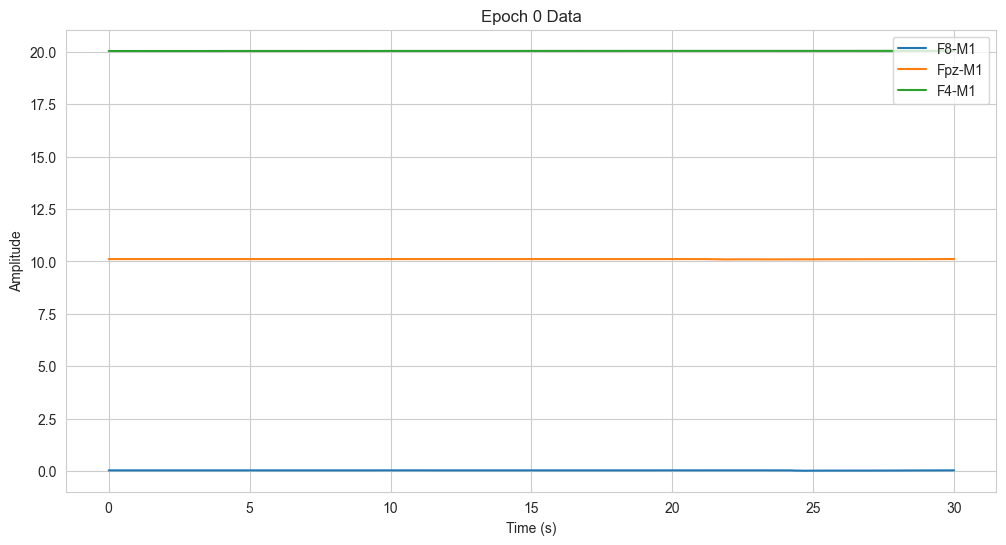

In [73]:
import matplotlib.pyplot as plt

def plot_epoch_data(raw, epoch_index, epoch_duration=30):
    """
    Plots the 30-second data from the raw MNE object for a given epoch index.

    Parameters:
    raw (mne.io.Raw): The raw MNE object containing the data.
    epoch_index (int): The index of the epoch to plot.
    epoch_duration (int): The duration of each epoch in seconds (default is 30 seconds).
    """
    # Calculate the start and end times for the given epoch
    start_time = epoch_index * epoch_duration
    end_time = start_time + epoch_duration

    # Extract the data for the specified time range
    data, times = raw[:, int(start_time * raw.info['sfreq']):int(end_time * raw.info['sfreq'])]

    # Plot the extracted data
    plt.clf()
    plt.figure(figsize=(12, 6))
    for i, channel in enumerate(raw.info['ch_names']):
        plt.plot(times, data[i] + i * 10, label=channel)  # Offset each channel for better visualization

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Epoch {epoch_index} Data')
    plt.legend(loc='upper right')
    plt.show()

# Example usage:
plot_epoch_data(raw, epoch_index=0)

## Visualising epochs

In [87]:
def plot_epoch(epoch):
    row = df.loc[epoch]
    mne_filtered.plot(start = epoch * 30, duration = 30, scalings = 'auto')
    return row

plot_epoch(149)


Stage                                                 N2
Confidence                                      0.624099
Epoch                                                149
Timestamp            2024-08-26 22:10:40.722846031+01:00
Source                                             F4-M1
F8-M1_Stage                                            W
F8-M1_Confidence                                0.390146
Fpz-M1_Stage                                           W
Fpz-M1_Confidence                               0.610233
F4-M1_Stage                                           N2
F4-M1_Confidence                                0.624099
StageInt                                               2
EventTimes            [2024-08-26 22:11:03.820000+01:00]
ManualStage                                            W
Name: 149, dtype: object

Stage                                                 N2
Confidence                                      0.624099
Epoch                                                149
Timestamp            2024-08-26 22:10:40.722846031+01:00
Source                                             F4-M1
F8-M1_Stage                                            W
F8-M1_Confidence                                0.390146
Fpz-M1_Stage                                           W
Fpz-M1_Confidence                               0.610233
F4-M1_Stage                                           N2
F4-M1_Confidence                                0.624099
StageInt                                               2
EventTimes            [2024-08-26 22:11:03.820000+01:00]
ManualStage                                            W
Name: 149, dtype: object

In [89]:
df.loc[df['Stage'] == 'N3']


,Stage,Confidence,Epoch,Timestamp,Source,F8-M1_Stage,F8-M1_Confidence,Fpz-M1_Stage,Fpz-M1_Confidence,F4-M1_Stage,F4-M1_Confidence,StageInt,EventTimes,ManualStage
231,N3,0.692605,231,2024-08-26 22:51:40.722846031+01:00,Fpz-M1,N2,0.587836,N3,0.692605,N3,0.692387,3,[],None
232,N3,0.784311,232,2024-08-26 22:52:10.722846031+01:00,F4-M1,N3,0.676754,N3,0.749888,N3,0.784311,3,[],None
233,N3,0.825715,233,2024-08-26 22:52:40.722846031+01:00,Fpz-M1,N3,0.568894,N3,0.825715,N3,0.813387,3,[],None
234,N3,0.860277,234,2024-08-26 22:53:10.722846031+01:00,Fpz-M1,N3,0.645621,N3,0.860277,N3,0.789701,3,[],None
235,N3,0.881545,235,2024-08-26 22:53:40.722846031+01:00,F4-M1,N3,0.825214,N3,0.880640,N3,0.881545,3,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,N3,0.831245,1092,2024-08-27 06:02:10.722846031+01:00,Fpz-M1,N3,0.618490,N3,0.831245,N3,0.806684,3,[],None
1093,N3,0.782206,1093,2024-08-27 06:02:40.722846031+01:00,Fpz-M1,N3,0.538020,N3,0.782206,N3,0.718698,3,[],None
1094,N3,0.874177,1094,2024-08-27 06:03:10.722846031+01:00,Fpz-M1,N3,0.697637,N3,0.874177,N3,0.838676,3,[],None
1095,N3,0.873636,1095,2024-08-27 06:03:40.722846031+01:00,F4-M1,N3,0.692162,N3,0.856490,N3,0.873636,3,[],None


In [92]:
plot_epoch(668)

Stage                                                 N3
Confidence                                      0.957068
Epoch                                                668
Timestamp            2024-08-27 02:30:10.722846031+01:00
Source                                             F8-M1
F8-M1_Stage                                           N3
F8-M1_Confidence                                0.957068
Fpz-M1_Stage                                          N3
Fpz-M1_Confidence                               0.956393
F4-M1_Stage                                           N3
F4-M1_Confidence                                0.953322
StageInt                                               3
EventTimes                                            []
ManualStage                                         None
Name: 668, dtype: object